# H1C IDR3 Power Spectra

Josh Dillon (adapted from the [work of Nick Kern](https://github.com/HERA-Team/H1C_IDR2/blob/master/notebooks/pspec_progress/power_spectrum_integration.ipynb)).

## Settings

In [1]:
prefix = '' # append this string to the front of all filenames
figures_folder = 'figures_uksrc' # where to save resultant figures
results_folder = 'results_files_uksrc' # where to save final Delta^2 uvpspec objects
import os
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)
if not os.path.exists(results_folder):
    os.makedirs(results_folder)    

In [2]:
# file containing final per-baseline power spectra 
df = '/lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/LSTBIN/all_epochs_preprocessed/pspec/pspec.grp1.of1.LPXLTK.h5'

# file containing matching power spectra without cross-talk subtraction
no_xtalk_df = '/lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/LSTBIN/all_epochs_preprocessed/pspec/pspec.grp1.of1.LPLTK.h5'

In [3]:
# overall signal loss corrections, per band
abscal_bias = {0: 1.0, 1: 1.0}  # this goes into data and errors  
other_bias = {0: 1.055, 1: 1.072}  # this goes into just data

In [4]:
# LST ranges of fields
lstcuts = [(-2.5, 0), # Field A
           (0.75, 2.75), # Field B
           (4, 6.25), # Field C
           (6.25, 9.25), # Field D
           (9.25, 14.75),  # Field E
          ]

lst_colors = ['limegreen', 'gold', 'cyan', 'deeppink', 'mediumorchid', 'aquamarine']

In [5]:
# Parameters for |SNR| analysis
SNR_fields_to_use = [1, 2, 3] # (i.e. B, C, D): these are the fields to look for excess systematics
xtalk_dly_min = 800 # ns
xtalk_dly_max = 1500 # ns
high_dly_diff = 2000 # ns (amount to increase above delays for comparison to noise-dominated delays)

# Parameters of |SNR| cuts
auto_xtalk_snr_cut = 1.5

In [6]:
# Spherical Binning Cuts
wedge_buff_ns = 300
sph_minimum_ew_distance = 15
sph_minimum_bl_length = 0
sph_maximum_bl_length = 1e100

# Spherical Binning Parameters
dk_multiplier = 2.0 # the size of each spherical k bin (Delta k) when multiplied by the natural k_para spacing
k_start_multiplied = .75 # the center of first spherical k bin in units of Delta k

## Imports

In [7]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import glob
import warnings
import hera_cal as hc
import hera_pspec as hp
from pyuvdata import UVBeam, UVData, UVCal, UVFlag, utils as uvutils
import pyuvdata
from scipy import stats, signal, interpolate
import scipy
# from memory_profiler import memory_usage
import copy
import time
import matplotlib.gridspec as gridspec
from astropy import constants, units, coordinates as crd
from astropy.time import Time
import uvtools as uvt
import pandas as pd
from IPython.display import display, HTML
import git  # pip install gitpython
import simpleqe as sqe

In [8]:
# These lines don't seem to work for the installed matplotlib
# in the UKSRC environment
# from matplotlib import rc
# rc('font',**{'family':'serif', 'serif':['times new roman'], 'size': 18})
# rc('text', usetex=true)

In [9]:
# add utils.py helper IO and plotting functions to path
import sys
import importlib
sys.path.insert(1, "../")
sys.path.insert(1, "../../")
sys.path.insert(1, "../../../")
import utils
importlib.reload(utils);

In [10]:
# print git hashes and versions
for module in [pyuvdata, hp, hc]:
    vs = getattr(module, "__version__", None)
    try:
        gh = git.Repo('/'.join(module.__path__[0].split('/')[:-1])).head.commit.hexsha
    except:
        if hasattr(module, "version"):
            gh = module.version.git_hash
        else:
            gh = 'None'
    print("Module {:<11}....\tVersion {:<7}.......\tGit {:<20}".format(module.__name__, vs[:7], gh[:20]))

Module pyuvdata   ....	Version 2.4.4  .......	Git None                
Module hera_pspec ....	Version 0.4.1  .......	Git None                
Module hera_cal   ....	Version 3.5    .......	Git None                


# Show Flags and Bands

In [15]:
spw_ranges = [[176, 340], [535, 697]] # these can be found in the pspec histories
hand_flag_files = glob.glob('/lustre/aoc/projects/hera/crhwalke/UKSRC-copies/hand_flags/*hand_flags.h5')
# JB needed to set run_check=False to get this sort to work.  I think there's an
# issue with backwards compatibility as these hand flag files were generated with
# an old version of pyuvdata (2.1.6.dev19+g6c831385) and the UKSRC environment
# uses pyuvdata 2.4.4
hand_flag_files = sorted(hand_flag_files, key=lambda f: np.mean(UVFlag(f, run_check=False).time_array))
# For the same reason as above, I had to set run_check=False here too
uvf = UVFlag(hand_flag_files, run_check=False)
lsts = np.unwrap(uvf.lst_array) * 12 / np.pi
while np.max(lsts) > 24:
    lsts -= 24
freqs = uvf.freq_array / 1e6

channel_width not available in file, computing it from the freq_array spacing.
telescope_name not available in file, so telescope related parameters cannot be set. This will result in errors when the object is checked. To avoid the errors, either set the `telescope_name` parameter or use `run_check=False` to turn off the check.


# Demonstrate Need For Per-Epoch Crosstalk Removal

# Load power spectrum container

In [11]:
# load get pspec container for cross-talk subtracted files
psc = hp.container.PSpecContainer(df, keep_open=False)
uvps_xtk, lens, angs, Nblps = utils.load_red_uvps(psc, 'stokespol', proj_EW_cut=14., spws=[0, 1], polpairs=['pI'])

In [ ]:
# load get pspec container for files without cross-talk subtraction
# psc = hp.container.PSpecContainer(no_xtalk_df, keep_open=False)
# uvps_tk, lens, angs, Nblps = utils.load_red_uvps(psc, 'stokespol', proj_EW_cut=14., spws=[0, 1], polpairs=['pI'])

In [12]:
# P_SN correction
for uvp in uvps_xtk:
    hp.utils.apply_P_SN_correction(uvp, P_SN='P_SN', P_N='P_N')

invalid value encountered in divide


In [ ]:
# copy stats array from xtk to tk for consistency
# for uvp_xtk, uvp_tk in zip(uvps_xtk, uvps_tk):
#     # if foreground dependent in uvp_xtk, rename it as P_SN
#     if "foreground_dependent_diag" in uvp_xtk.stats_array:
#         uvp_xtk.stats_array['P_SN'] = uvp_xtk.stats_array.pop('foreground_dependent_diag')
#     # ensure its real-valued: foreground_dependent_diag returns complex valued array
#     for stat in uvp_xtk.stats_array:
#         for spw in uvp_xtk.spw_array:
#             uvp_xtk.stats_array[stat][spw] = uvp_xtk.stats_array[stat][spw].real
#             nans = np.isnan(uvp_xtk.stats_array[stat][spw])
#             uvp_xtk.stats_array[stat][spw][nans] = np.inf
#     uvp_tk.stats_array = copy.deepcopy(uvp_xtk.stats_array)

In [13]:
pd.options.display.float_format = '{:.2f}'.format
pd.DataFrame([np.around(lens,1), angs, Nblps], index=['length [m]', 'angle [deg]', 'Nbl pairs'])

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
length [m],15.00,25.00,25.00,29.00,29.00,29.00,39.00,39.00,39.00,39.00,...,116.00,116.00,116.00,117.00,117.00,120.00,120.00,120.00,125.00,125.00
angle [deg],0.00,30.00,150.00,0.00,60.00,120.00,19.00,41.00,139.00,161.00,...,79.00,101.00,139.00,60.00,120.00,72.00,108.00,132.00,114.00,126.00
Nbl pairs,1156.00,625.00,625.00,729.00,625.00,529.00,324.00,441.00,400.00,441.00,...,1.00,1.00,1.00,1.00,4.00,1.00,1.00,1.00,1.00,1.00


In [ ]:
# apply bias correction
# for uvp_xtk, uvp_tk in zip(uvps_xtk, uvps_tk):
#     utils.bias_correction(uvp_xtk, abscal_bias, other_bias)
#     utils.bias_correction(uvp_tk, abscal_bias, other_bias)
for uvp_xtk in uvps_xtk:
    utils.bias_correction(uvp_xtk, abscal_bias, other_bias)

# Initial Data Quality Checks

# Analysis of Residual Cross-Talk

# Incoherent redundant (cylindrically) average

In [15]:
import pickle
with open(f'figures/crosstalk_flagging_plot_variables.p', 'rb') as f:
    xtalk_flag_dict = pickle.load(f)

In [16]:
flag_neg_delays = xtalk_flag_dict['flag_neg_delays']
flag_pos_delays = xtalk_flag_dict['flag_pos_delays']
flag_all_delays = xtalk_flag_dict['flag_all_delays']
xtalk_dly_min = xtalk_flag_dict['xtalk_dly_min']
xtalk_dly_max = xtalk_flag_dict['xtalk_dly_max']

In [17]:
# weight redundant average by P_N, but propagate P_SN errorbar
history = "Bias Corrected:\ndata + error bias correction per spw {}\nother data-only bias correction per spw{}\n" \
          "Incoherent redundantly averaged, excluding auto-baseline-pairs, weighted by P_N" \
          "".format(abscal_bias, other_bias)
uvp_xtk_ravg = utils.red_avg(uvps_xtk, exclude_autos=True, error_weights='P_N', error_field=['P_SN'], add_to_history=history,
                             flag_all_delays=flag_all_delays, flag_pos_delays=flag_pos_delays, flag_neg_delays=flag_neg_delays)
# uvp_tk_ravg = utils.red_avg(uvps_tk, exclude_autos=True, error_weights='P_N', error_field=['P_SN'], add_to_history=history,
#                             flag_all_delays=flag_all_delays, flag_pos_delays=flag_pos_delays, flag_neg_delays=flag_neg_delays)

## Show $P(\tau = 0)$ and $P_N$ to help define fields

## Show stats after the redundant average

# 3. Incoherent time average in LST fields

In [18]:
# make LST cuts
fields_used = []
# uvp_xtk_tavg, uvp_tk_tavg = [], []
uvp_xtk_tavg = []
for field, lc in enumerate(lstcuts):
    # weight time-average by P_N
    history = "LST cut {} hours, average weighted by P_N".format(lc)
    lst_indexes = np.unique(uvp_xtk_ravg.lst_1_array, return_index=True)[1]
    lsts = np.array([uvp_xtk_ravg.lst_avg_array[i] for i in sorted(lst_indexes)])
    lsts_hrs = np.unwrap(lsts) * 12 / np.pi 
    while np.max(lsts_hrs) > 24:
        lsts_hrs -= 24
    
    lcut = (lsts_hrs >= lc[0]) & (lsts_hrs <= lc[1])
    if not np.any(lcut):
        continue
    fields_used.append(field)
    
    # average with cross-talk subtraction 
    u = uvp_xtk_ravg.select(lsts=lsts[lcut], inplace=False)
    u.average_spectra(time_avg=True, error_weights='P_N', error_field=['P_SN'], add_to_history=history)
    uvp_xtk_tavg.append(u)

    # # average without cross-talk subtraction
    # u = uvp_tk_ravg.select(lsts=lsts[lcut], inplace=False)
    # u.average_spectra(time_avg=True, error_weights='P_N', error_field=['P_SN'], add_to_history=history)
    # uvp_tk_tavg.append(u)

## Cylindrical Power Spectra and SNR

In [45]:
import pickle
with open(f'{figures_folder}/{prefix}uvp_xtk_tavg.p', 'wb') as f:
    pickle.dump(uvp_xtk_tavg, f)

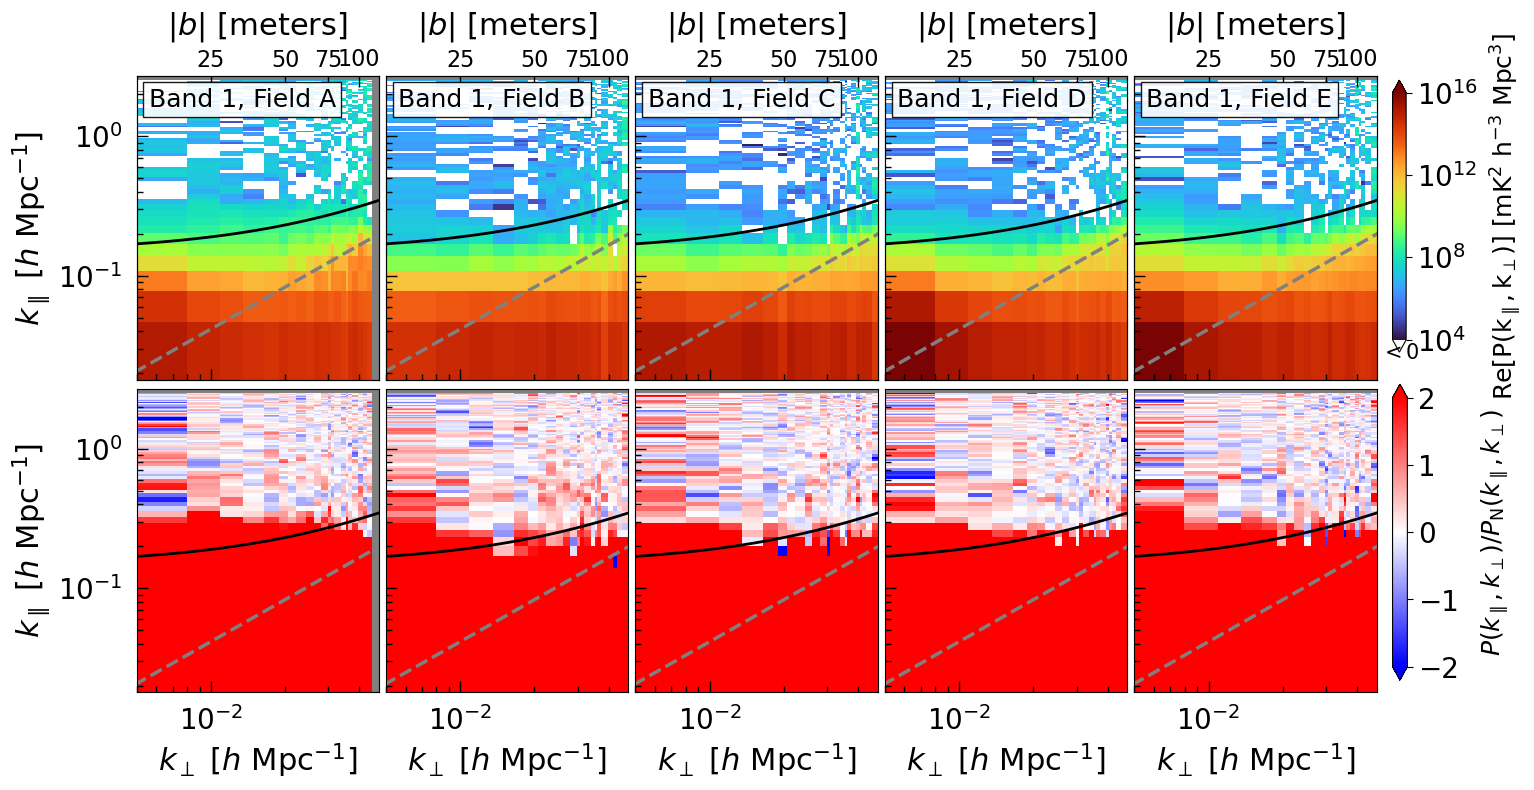

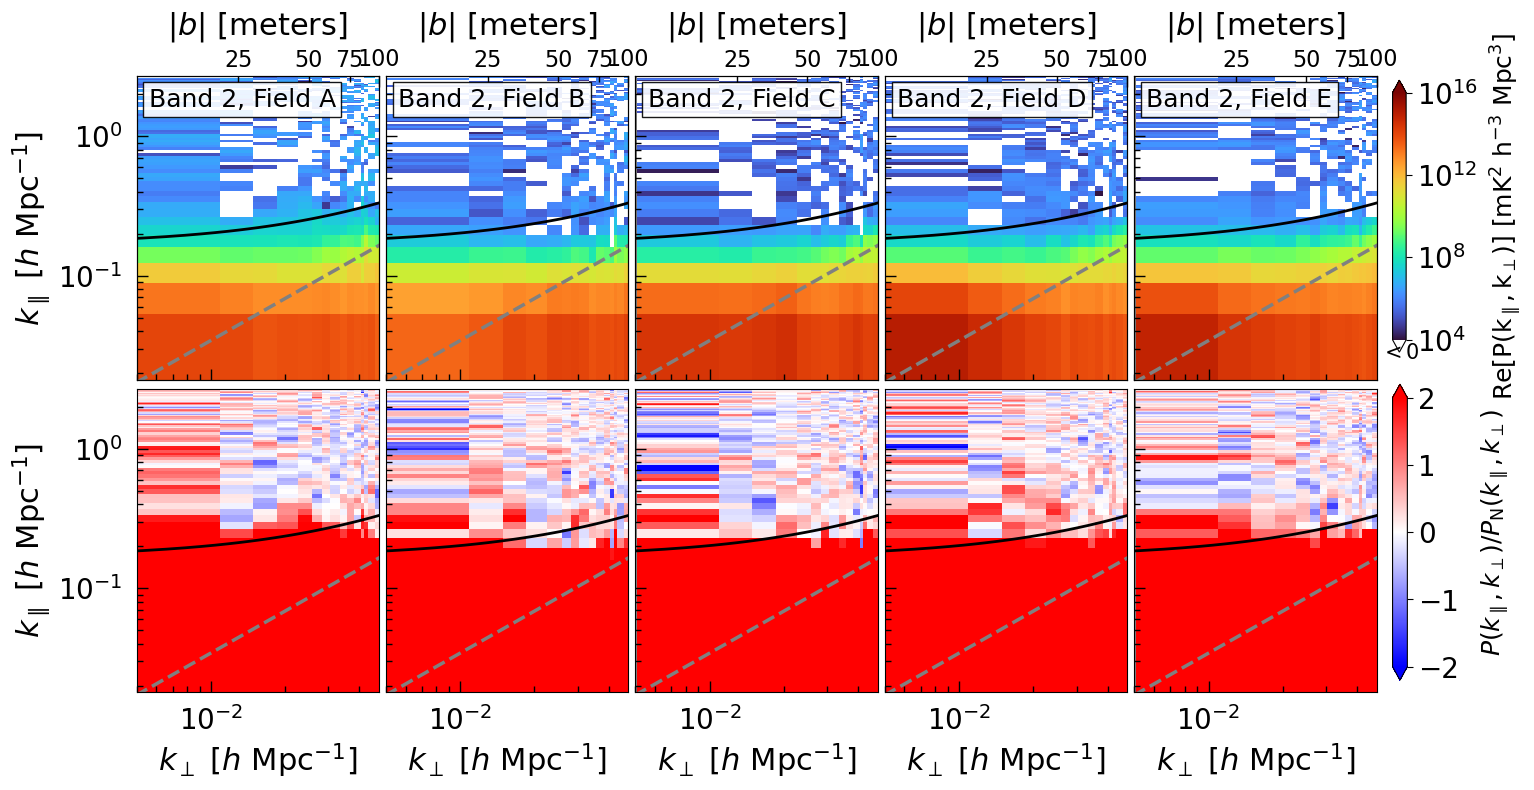

In [19]:
# basic settings
component = 'real'
cmap1 = copy.copy(plt.get_cmap("turbo"))
cmap1.set_bad('w')
if 'abs' in component:
    cmap1.set_under(plt.cm.turbo([0])[0])
else:
    cmap1.set_under('w')
cmap2 = plt.get_cmap("bwr")

xlim = 0.005, 0.048
ylim = 0.018, 2.7

for spw in [0, 1]:

    fig, axes = plt.subplots(2, len(uvp_xtk_tavg), figsize=(16, 8))
    fig.subplots_adjust(wspace=0.03, hspace=0.03)


    for i in range(2):
        for j in range(len(uvp_xtk_tavg)):
            ax = axes[i, j]
            ax.axvspan(0, 1, 0, 1, color='grey', zorder=0)
            
            # select only baseline pairs with finite noise
            u = copy.deepcopy(uvp_xtk_tavg[j])
            good_blps = set([])
            for key in u.get_all_keys():
                if key[0] == spw:
                    if np.all(np.isfinite(u.get_stats('P_N', key))):
                        good_blps.add(key[1])
            if len(good_blps) == 0:
                continue
            u.select(blpairs=sorted(good_blps))

            if i == 0:
                ax2, ax3 = utils.wedge_plot(u, ax, spw, dly_label=False, cmap=cmap1, component=component, error_weights='P_N',
                                            xlim=xlim, ylim=ylim, twinx=False, twiny=True, fontsize=22, log10=False,
                                            norm=matplotlib.colors.LogNorm(vmin=1e4, vmax=1e16))
                ax2.set_xticks([100], minor=False); ax2.set_xticklabels([100], minor=False)
                ax2.set_xticks([25, 50, 75], minor=True); ax2.set_xticklabels([25, 50, 75], minor=True)
            else:
                u.data_array[spw] /= u.stats_array['P_N'][spw].real
                ax2, ax3 = utils.wedge_plot(u, ax, spw, dly_label=False, cmap=cmap2, component=component, log10=False,
                                 xlim=xlim, ylim=ylim, fontsize=22, twinx=False, twiny=False, vmin=-2, vmax=2)
            ax.tick_params(labelsize=20)
            if j > 0:
                ax.set_yticklabels([])
                ax.set_ylabel('')
            if i == 0:
                ax.set_xticklabels([])
                ax.set_xlabel('')
            if i == 0:
                ax.text(0.05, 0.9, "Band {}, Field {}".format(spw+1, "ABCDEFGHIJ"[fields_used[j]]), fontsize=18, transform=ax.transAxes, 
                        color='k', bbox=dict(facecolor='w', alpha=0.9))
            # plot buffer
            x = np.linspace(5, 120)  # meters
            y = 1e9 / scipy.constants.c * x + wedge_buff_ns  # ns
            z = u.cosmo.f2z(np.mean(u.get_spw_ranges(spw)[0][:2]))
            kperp, kpara = x * u.cosmo.bl_to_kperp(z, little_h=True), y * u.cosmo.tau_to_kpara(z, little_h=True) / 1e9
            ax.plot(kperp, kpara, c='k', lw=2)

        if i == 0:
            cbax = fig.add_axes([0.825, 0.535, 0.1, 0.34])
        else:
            cbax = fig.add_axes([0.825, 0.125, 0.1, 0.37])
        cbax.axis('off')
        cax = ax.collections[0]
        extend = 'both' if i == 0 else 'both'
        cbar = fig.colorbar(cax, ax=cbax, extend=extend)
        cbar.ax.tick_params(labelsize=20, direction='out', size=4)
        if i== 0:
            cbar.set_label(r"$\rm{Re}[P(k_\parallel, k_\perp)]\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$", fontsize=18, labelpad=8)
            cbar.ax.set_xlabel("$< 0$", labelpad=2, fontsize=15)
        else:
            cbar.set_label(r"$P(k_\parallel, k_\perp) / P_{\rm N}(k_\parallel,k_\perp)$", fontsize=18, labelpad=15)

    plt.savefig(f'{figures_folder}/{prefix}Cylindrical_Pk_Band_{spw+1}.png', dpi=200)

## Cylindrical Power Spectrum Noise

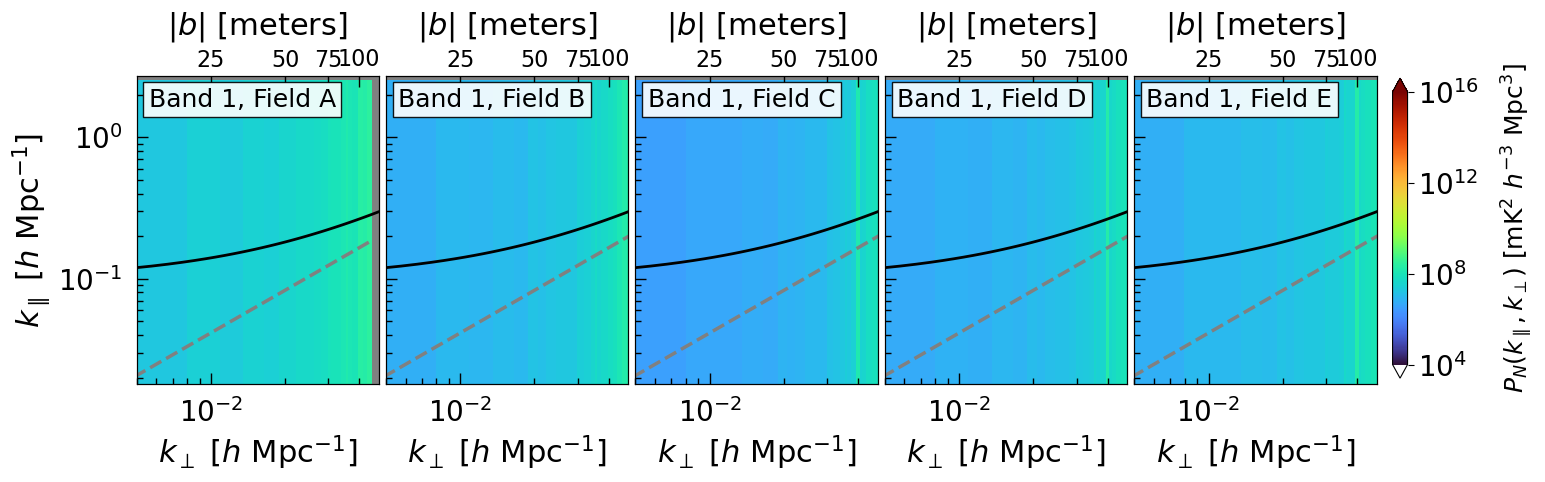

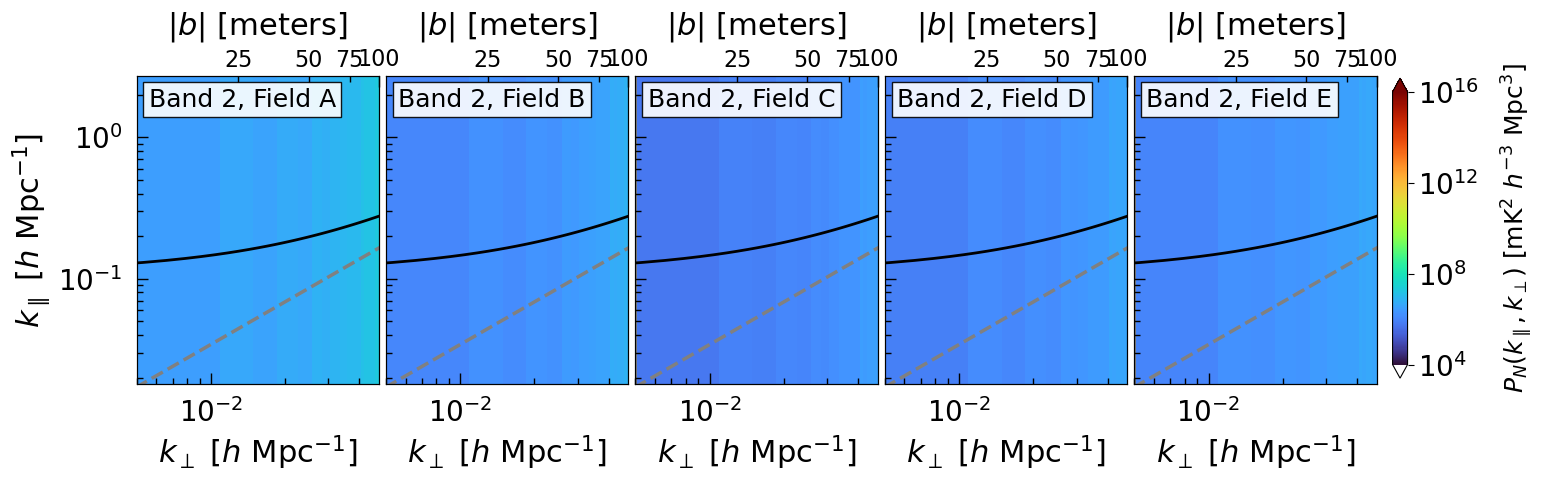

In [20]:
for spw in [0, 1]:
    fig, axes = plt.subplots(1, len(uvp_xtk_tavg), figsize=(16, 4))
    fig.subplots_adjust(wspace=0.03, hspace=0.03)
    for j in range(len(uvp_xtk_tavg)):
        ax = axes[j]
        ax.axvspan(0, 1, 0, 1, color='grey', zorder=0)

        # select only baseline pairs with finite noise
        u = copy.deepcopy(uvp_xtk_tavg[j])
        good_blps = set([])
        for key in u.get_all_keys():
            if key[0] == spw:
                if np.all(np.isfinite(u.get_stats('P_N', key))):
                    good_blps.add(key[1])
        if len(good_blps) == 0:
            continue
        u.select(blpairs=sorted(good_blps))
        
        u.data_array[spw] = copy.deepcopy(u.stats_array['P_N'][spw])

        ax2, ax3 = utils.wedge_plot(u, ax, spw, dly_label=False, cmap=cmap1, component=component, error_weights='P_N',
                                    xlim=xlim, ylim=ylim, twinx=False, twiny=True, fontsize=22, log10=False,
                                    norm=matplotlib.colors.LogNorm(vmin=1e4, vmax=1e16))
        ax2.set_xticks([100], minor=False); ax2.set_xticklabels([100], minor=False)
        ax2.set_xticks([25, 50, 75], minor=True); ax2.set_xticklabels([25, 50, 75], minor=True)
        ax.tick_params(labelsize=20)
        if j > 0:
            ax.set_yticklabels([])
            ax.set_ylabel('')
        ax.text(0.05, 0.9, "Band {}, Field {}".format(spw+1, "ABCDEFGHIJ"[fields_used[j]]), fontsize=18, transform=ax.transAxes,
                bbox=dict(facecolor='w', alpha=0.9))

        # plot buffer
        x = np.linspace(5, 120)  # meters
        y = 1e9 / scipy.constants.c * x + 200  # ns
        z = u.cosmo.f2z(np.mean(u.get_spw_ranges(spw)[0][:2]))
        kperp, kpara = x * u.cosmo.bl_to_kperp(z, little_h=True), y * u.cosmo.tau_to_kpara(z, little_h=True) / 1e9
        ax.plot(kperp, kpara, c='k', lw=2)

    cbax = fig.add_axes([0.825, 0.125, 0.1, 0.75])
    cbax.axis('off')
    cax = ax.collections[0]
    cbar = fig.colorbar(cax, ax=cbax, extend='both')
    cbar.ax.tick_params(labelsize=20, direction='out', size=4)
    cbar.set_label(r"$P_N(k_\parallel, k_\perp)\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$", fontsize=18, labelpad=15)
    
    plt.savefig(f'{figures_folder}/{prefix}Cylindrical_P_N_Band_{spw+1}.png', dpi=200)

## Explore the distribution of noise-like bins

# Spherical average

In [21]:
# load a single dummy file
uvd = UVData()
uvd.read("/lustre/aoc/projects/hera/crhwalke/UKSRC-copies/LPXLTK/" \
         "zen.grp1.of1.LST.0.64367.sum.LPXLTK.uvh5", bls=[(12, 13), (12, 12), (13, 13)], polarizations=['pI'])
uvd.select(times=uvd.time_array[:1])

Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array. Largest imaginary component was 82.01000262092698, largest imaginary/real ratio was 0.014946804892442465.


In [22]:
# initialize pspecdata
beam = hp.PSpecBeamUV('/lustre/aoc/projects/hera/crhwalke/UKSRC-copies/healpix/NF_HERA_IQ_power_beam_healpix128.fits')
ds = hp.PSpecData(dsets=[uvd], wgts=[None], beam=beam)
ds.Jy_to_mK()

# get spw
u = uvp_xtk_ravg
spw_ranges = u.get_spw_ranges()
spw_ranges = [np.where((uvd.freq_array[0] >= sr[0]-1e-9)&(uvd.freq_array[0] <= sr[1]+1e-9))[0] for sr in spw_ranges]
spw_ranges = [(sr[0], sr[-1]) for sr in spw_ranges]

# run pspec with parameters in file history
_u = ds.pspec([(12, 13)], [(12, 13)], (0, 0), u.get_polpairs(), input_data_weight=u.weighting,
             norm=u.norm, taper=u.taper, little_h='h^-3' in u.norm_units, spw_ranges=spw_ranges, store_cov=True,
             store_window=True, verbose=False, cov_model='autos')

Producing time-uniform covariance matrices between bandpowers.
Casting complex values to real discards the imaginary part


In [25]:
# insert window functions into uvp
wf = _u.window_function_array[0]
for ut in uvp_xtk_tavg:
    ut.window_function_array = {k: np.repeat(_u.window_function_array[k], ut.Nblpairts, axis=0) for k in _u.spw_array}

In [26]:
# insert covariance: ad hoc b/c computing covariance for each blpair is too expensive, and noise cov is simple
norm_cov = {}
ut = uvp_xtk_tavg[0]
for spw in ut.spw_array:
    norm_cov[spw] = _u.cov_array_real[spw].squeeze()
    norm_cov[spw] /= _u.cov_array_real[spw].squeeze().diagonal().mean()

In [28]:
# Path to files necessary for exact window function computation
path_to_wf = '/lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/LSTBIN/all_epochs_preprocessed/pspec/delay_wf/'

# uvp_xtk_sph_1, uvp_tk_sph_1 = [], []
# uvp_xtk_sph_2, uvp_tk_sph_2 = [], []
uvp_xtk_sph_1 = []
uvp_xtk_sph_2 = []

# spherical average onto wide LOS k grid
# note that only covariance arrays will be reliable, as stats_arrays cannot account for bin2bin correlation
for band in range(2):
    print('\nBand {}'.format(band+1))
    # set dk separately for each band   
    dk = dk_multiplier * np.median(np.diff(uvp_xtk_tavg[0].get_kparas(band)))
    kbins = np.arange(k_start_multiplied * dk, 2.5, dk) # even spacing 

    # for uvp_xtk, uvp_tk, field in list(zip(uvp_xtk_tavg, uvp_tk_tavg, list('ABCDE'))): #loop over fields
    for uvp_xtk, field in list(zip(uvp_xtk_tavg, list('ABCDE'))):  # loop over fields
        print('* Field {}'.format(field))
        
        # deepcopy
        # u_xtk, u_tk = copy.deepcopy(uvp_xtk), copy.deepcopy(uvp_tk)
        u_xtk = copy.deepcopy(uvp_xtk)
        # make a covariance based on norm_cov, scaled by P_N and P_SN if detection is > 2 sigma
        utils.stat_to_cov(u_xtk, 'P_SN', norm_cov)
        # set P_N for all k_para modes below horizon delay + wedge_buff to large value
        u_xtk.set_stats_slice('P_N', 1e9 / scipy.constants.c, wedge_buff_ns, above=False, val=np.inf)
        # u_tk.set_stats_slice('P_N', 1e9 / scipy.constants.c, wedge_buff_ns, above=False, val=np.inf)

        # cut baselines by setting noise to infinity
        for blp, blvec in zip(u_xtk.get_blpairs(), u_xtk.get_blpair_blvecs()):
            cut = False
            if np.linalg.norm(blvec) < sph_minimum_bl_length:
                cut = True
            if np.linalg.norm(blvec) > sph_maximum_bl_length:
                cut = True
            if np.abs(blvec[0]) < sph_minimum_ew_distance:
                cut = True
            if cut:
                for spw in u_xtk.spw_array:
                    for pp in u_xtk.get_polpairs():
                        k = (spw, blp, pp)
                        # u_tk.set_stats('P_N', k, np.ones_like(u_tk.get_stats('P_N', k)) * np.inf)
                        u_xtk.set_stats('P_N', k, np.ones_like(u_xtk.get_stats('P_N', k)) * np.inf)

        # Get exact window functions
        # At this stage, their are not weighted. Weights are applied when calling 
        # hp.grouping.spherical_average with error_weights='P_N'
        filename = path_to_wf+'u_xtk_nw_field{}.hdf5'.format(field)
        if os.path.exists(filename):
            print(f'  Using window function found in {filename}')
            u_windows = hp.UVPSpec()
            u_windows.read_hdf5(filename)
            setattr(u_xtk, "window_function_array", u_windows.window_function_array)
            setattr(u_xtk, "window_function_kperp", u_windows.window_function_kperp)
            setattr(u_xtk, "window_function_kpara", u_windows.window_function_kpara)
            setattr(u_xtk, "exact_windows", True)           
            u_xtk.history += f'\n  Window functions replaced with those from {filename}\n\n'
        else:
            t0 = time.time()
            # compute window functions
            u_xtk.get_exact_window_functions(ftbeam_file=path_to_wf+'FT_beam_HERA_dipole', inplace=True,
                                             x_orientation=uvd.x_orientation, verbose=False)
            t1 = time.time()
            print('  Window function computation took %.1f mins.' %((t1-t0)/60))
            u_xtk.write_hdf5(filename, overwrite=False)

        # spherical average
        history = "average weighted by P_N, with {} ns wedge buffer exclusion".format(wedge_buff_ns)
        sph_xtk = hp.grouping.spherical_average(u_xtk, kbins, dk, error_weights='P_N', add_to_history=history)
        # sph_tk = hp.grouping.spherical_average(u_tk, kbins, dk, error_weights='P_N', add_to_history=history)
        # but wait: repeat with P_N scaled norm_cov to get proper P_N level (only needed if dk > 0.032)
        utils.stat_to_cov(u_xtk, 'P_N', norm_cov)

        sph2 = hp.grouping.spherical_average(u_xtk, kbins, dk, error_weights='P_N')
        for spw in sph_xtk.spw_array:
            sph_xtk.stats_array['P_N'][spw][0, :, 0] = np.sqrt(np.diagonal(sph2.cov_array_real[spw].squeeze()))
        # remove P_SN in stats array to avoid confusion
        sph_xtk.stats_array.pop('P_SN')
        # append
        if band == 0:            
            uvp_xtk_sph_1.append(sph_xtk)
            # uvp_tk_sph_1.append(sph_tk)
        else:
            uvp_xtk_sph_2.append(sph_xtk)
            # uvp_tk_sph_2.append(sph_tk)   


Band 1
* Field A


invalid value encountered in matmul
invalid value encountered in multiply


  Using window function found in /lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/LSTBIN/all_epochs_preprocessed/pspec/delay_wf/u_xtk_nw_fieldA.hdf5


invalid value encountered in multiply
invalid value encountered in multiply


* Field B
  Using window function found in /lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/LSTBIN/all_epochs_preprocessed/pspec/delay_wf/u_xtk_nw_fieldB.hdf5
* Field C
  Using window function found in /lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/LSTBIN/all_epochs_preprocessed/pspec/delay_wf/u_xtk_nw_fieldC.hdf5
* Field D
  Using window function found in /lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/LSTBIN/all_epochs_preprocessed/pspec/delay_wf/u_xtk_nw_fieldD.hdf5
* Field E
  Using window function found in /lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/LSTBIN/all_epochs_preprocessed/pspec/delay_wf/u_xtk_nw_fieldE.hdf5

Band 2
* Field A
  Using window function found in /lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/LSTBIN/all_epochs_preprocessed/pspec/delay_wf/u_xtk_nw_fieldA.hdf5
* Field B
  Using window function found in /lustre/aoc/projects/hera/H1C_IDR3/IDR3_2/LSTBIN/all_epochs_preprocessed/pspec/delay_wf/u_xtk_nw_fieldB.hdf5
* Field C
  Using window function found in /lustre/aoc/projects/hera/H1C_IDR3/ID

## Examine binning choices

## Plot single $\Delta^2(k)$ with window functions

In [29]:
# convert to dsq
uvp_xtk_dsq_1 = []
for u in uvp_xtk_sph_1:
    uvp_xtk_dsq_1.append(u.convert_to_deltasq(inplace=False))
uvp_xtk_dsq_2 = []
for u in uvp_xtk_sph_2:
    uvp_xtk_dsq_2.append(u.convert_to_deltasq(inplace=False))    

True


invalid value encountered in divide


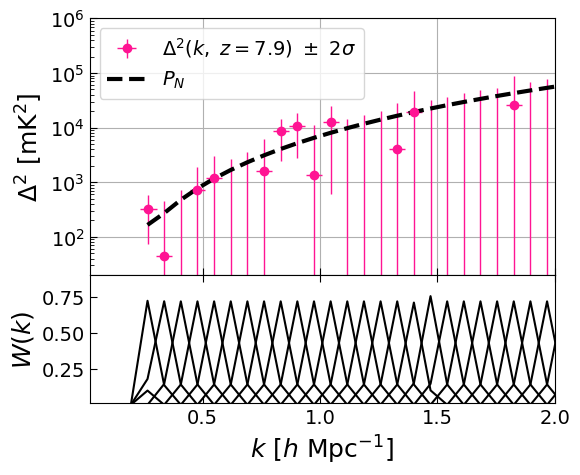

In [30]:
fig = plt.figure(figsize=(6, 5), dpi=100)
fig.subplots_adjust(hspace=0.0)

# set params
plot_window = True
component = 'real'
field = 2 # C

spw = 1
uvp_xtk_dsq = [uvp_xtk_dsq_1, uvp_xtk_dsq_2][spw]
u = uvp_xtk_dsq[fields_used.index(field)]
print(u.exact_windows)
kp = u.get_kparas(spw)
ks = slice(np.argmin(np.abs(kp - 0.128)), None, 1)
c = 'deeppink'

# get data
y = u.data_array[spw].real.squeeze().copy()[ks].copy()
y[y < 0] *= 0
yerr = np.sqrt(u.cov_array_real[spw].squeeze().diagonal())[ks]
pn = u.stats_array['P_N'][spw].real.squeeze()[ks]
pn[pn <= 0] = np.nan
kbins = u.get_kparas(spw)
k = kbins[ks]
z = u.cosmo.f2z(np.mean(u.get_spw_ranges()[spw][:2]))
xlim = .02, 2

# get x errorbars from window func
x, xerr_low, xerr_hi = sqe.utils.interp_Wcdf(u.window_function_array[spw].squeeze(), kbins)
xerr = np.array([xerr_low, xerr_hi]).T[ks]

grid = gridspec.GridSpec(3, 3)
if plot_window:
    ax = fig.add_subplot(grid[:2, :])
else:
    ax = fig.add_subplot(grid[:, :])

if component == 'abs-real':
    p1 = ax.errorbar(k, np.abs(y), marker='o', ms=6, ls='', yerr=yerr * 2, c=c)
else:
    p1 = ax.errorbar(k, np.real(y), marker='o', ms=6, ls='',
                     yerr=yerr * 2, c=c, xerr=xerr.T, lw=1)

p2, = ax.plot(k, pn, c='k', ls='--', lw=3)

ax.tick_params(labelsize=14, direction='in', size=5)
ax.tick_params(direction='in', size=3, which='minor')
ax.set_yscale('log')
ax.grid()
ax.set_xlim(xlim)
ax.set_ylim(2e1, 1e6)
ax.legend([p1, p2], [r'$\Delta^2(k,\ z={:.1f})\ \pm\ 2\sigma$'.format(z), r'$P_N$'],
          fontsize=14, loc=2, ncol=1)
if not plot_window:
    ax.set_xlabel(r'$k\ [h\ {\rm Mpc}^{-1}$]', fontsize=18)
else:
    ax.set_xticklabels([])
ax.set_ylabel(r'$\Delta^2\ [{\rm mK}^2]$', fontsize=18)

if plot_window:
    ax = fig.add_subplot(grid[2:, :])
    ax.tick_params(labelsize=14, direction='in', size=5, top=True, bottom=True)
    ax.plot(kbins, u.window_function_array[spw].squeeze()[:, ks], c='k', lw=1.5)
    ax.set_xlim(xlim)
    ax.set_ylim(1e-2, 0.9)
    ax.set_xlabel(r'$k\ [h\ {\rm Mpc}^{-1}$]', fontsize=18)
    ax.set_ylabel(r"$W(k)$", fontsize=18)
    #ax.set_yscale('log')
    
#fig.savefig('plots/band2_field1_wf.pdf', dpi=100, bbox_inches='tight')
plt.savefig(f'{figures_folder}/{prefix}limits_band_{spw+1}_field_{"ABCDEFGHIJ"[field]}.png', dpi=200)

## Plot all $\Delta^2(k)$ (real and imaginary)

invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide


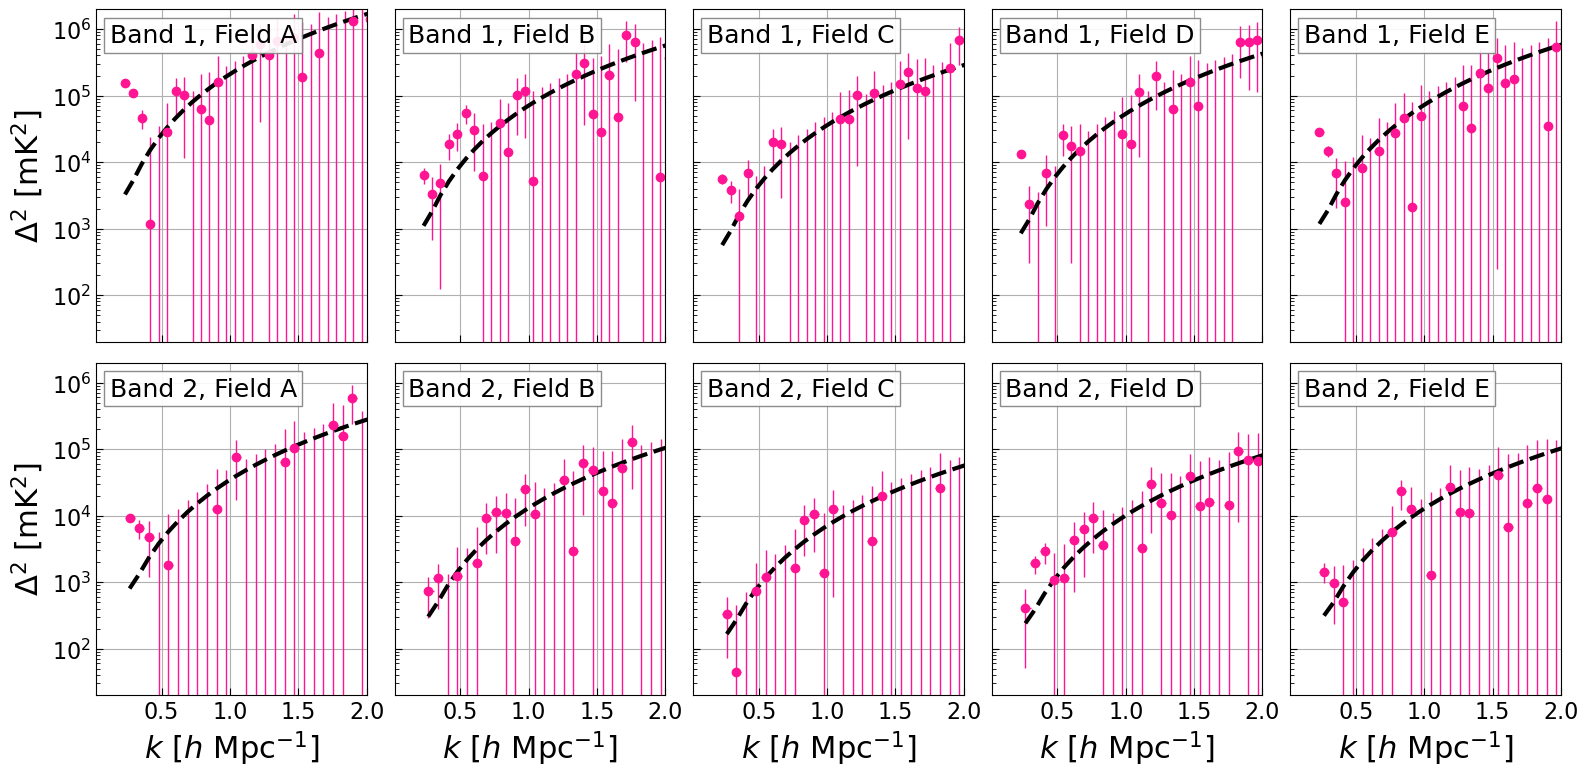

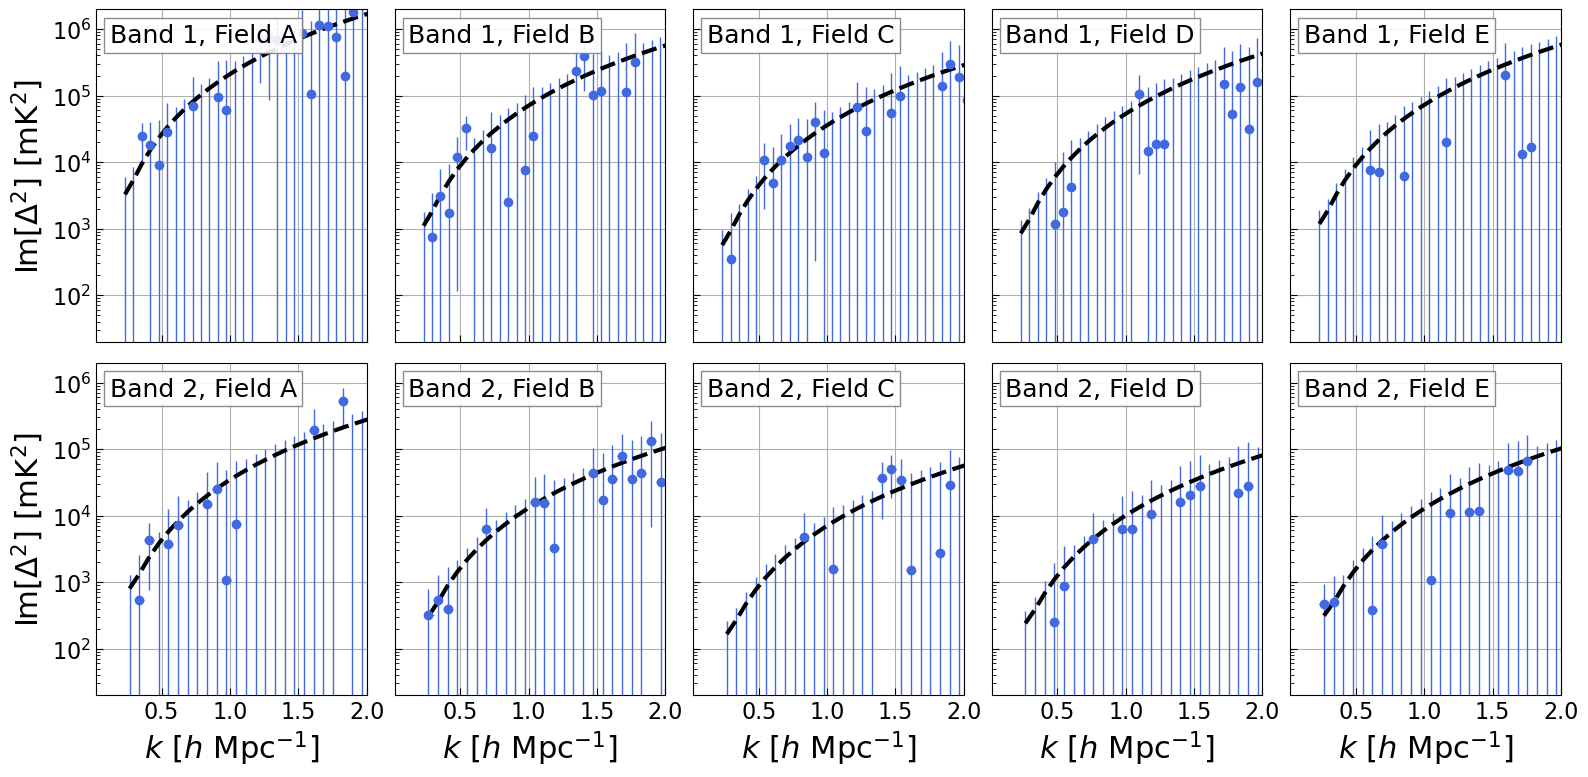

In [31]:
xlim = .02, 2
ylim = 2e1, 2e6

# loop over real and imaginary power spectra
for func, c in [(np.real, 'deeppink'), (np.imag, 'royalblue')]:
    fig, axes = plt.subplots(2, len(uvp_xtk_dsq_1), figsize=(16, 8))
    fig.subplots_adjust(wspace=0.05, hspace=0.05)

    for i in range(2):
        uvp_xtk_dsq = [uvp_xtk_dsq_1, uvp_xtk_dsq_2][i]
        for j in range(len(uvp_xtk_dsq)):
            # get data
            ax = axes[i, j]
            u = uvp_xtk_dsq[j]
            spw = i
            
            # get power spectra and vertical error bars
            y = func(u.data_array[spw].squeeze().copy()[ks].copy())
            y[y < 0] *= 0
            yerr = np.sqrt(np.diagonal(u.cov_array_real[spw].squeeze()))[ks]
            pn = u.stats_array['P_N'][spw].real.squeeze()[ks]
            pn[pn <= 0] = np.nan
            kbins = u.get_kparas(spw)
            k = kbins[ks]
            z = u.cosmo.f2z(np.mean(u.get_spw_ranges()[spw][:2]))       

            # get x errorbars from window func
            x, xerr_low, xerr_hi = sqe.utils.interp_Wcdf(u.window_function_array[spw].squeeze(), kbins)
            xerr = np.array([xerr_low, xerr_hi]).T[ks]
            # plot data
            p1 = ax.errorbar(k, y, marker='o', ms=6, ls='',
                             yerr=yerr * 2, c=c, xerr=xerr.T, lw=1)
            p2, = ax.plot(k, pn, c='k', ls='--', lw=3)

            # handle subplot
            ax.tick_params(labelsize=16, direction='in', size=5)
            ax.tick_params(direction='in', size=3, which='minor')
            ax.set_yscale('log')
            ax.grid()
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.text(0.05, 0.9, "Band {}, Field {}".format(i+1, "ABCDEFGHIJ"[fields_used[j]]), fontsize=18,
                    transform=ax.transAxes, bbox=dict(fc='w', ec='grey', alpha=0.9))
            if i == 0:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel(r"$k\ [h\ {\rm Mpc}^{-1}]$", fontsize=22)
            if j == 0:
                if func == np.real:
                    ax.set_ylabel(r"$\Delta^2\ [{\rm mK}^2]$", fontsize=22)
                else:
                    ax.set_ylabel(r"Im$[\Delta^2]\ [{\rm mK}^2]$", fontsize=22)
            else:    
                ax.set_yticklabels([])
    
    plt.tight_layout()
    if func == np.imag:
        plt.savefig(f'{figures_folder}/{prefix}all_imaginary_limits.png', dpi=200)
    else:
        plt.savefig(f'{figures_folder}/{prefix}all_limits.png', dpi=200)

## Plot all $P(k)$ on a linear scale

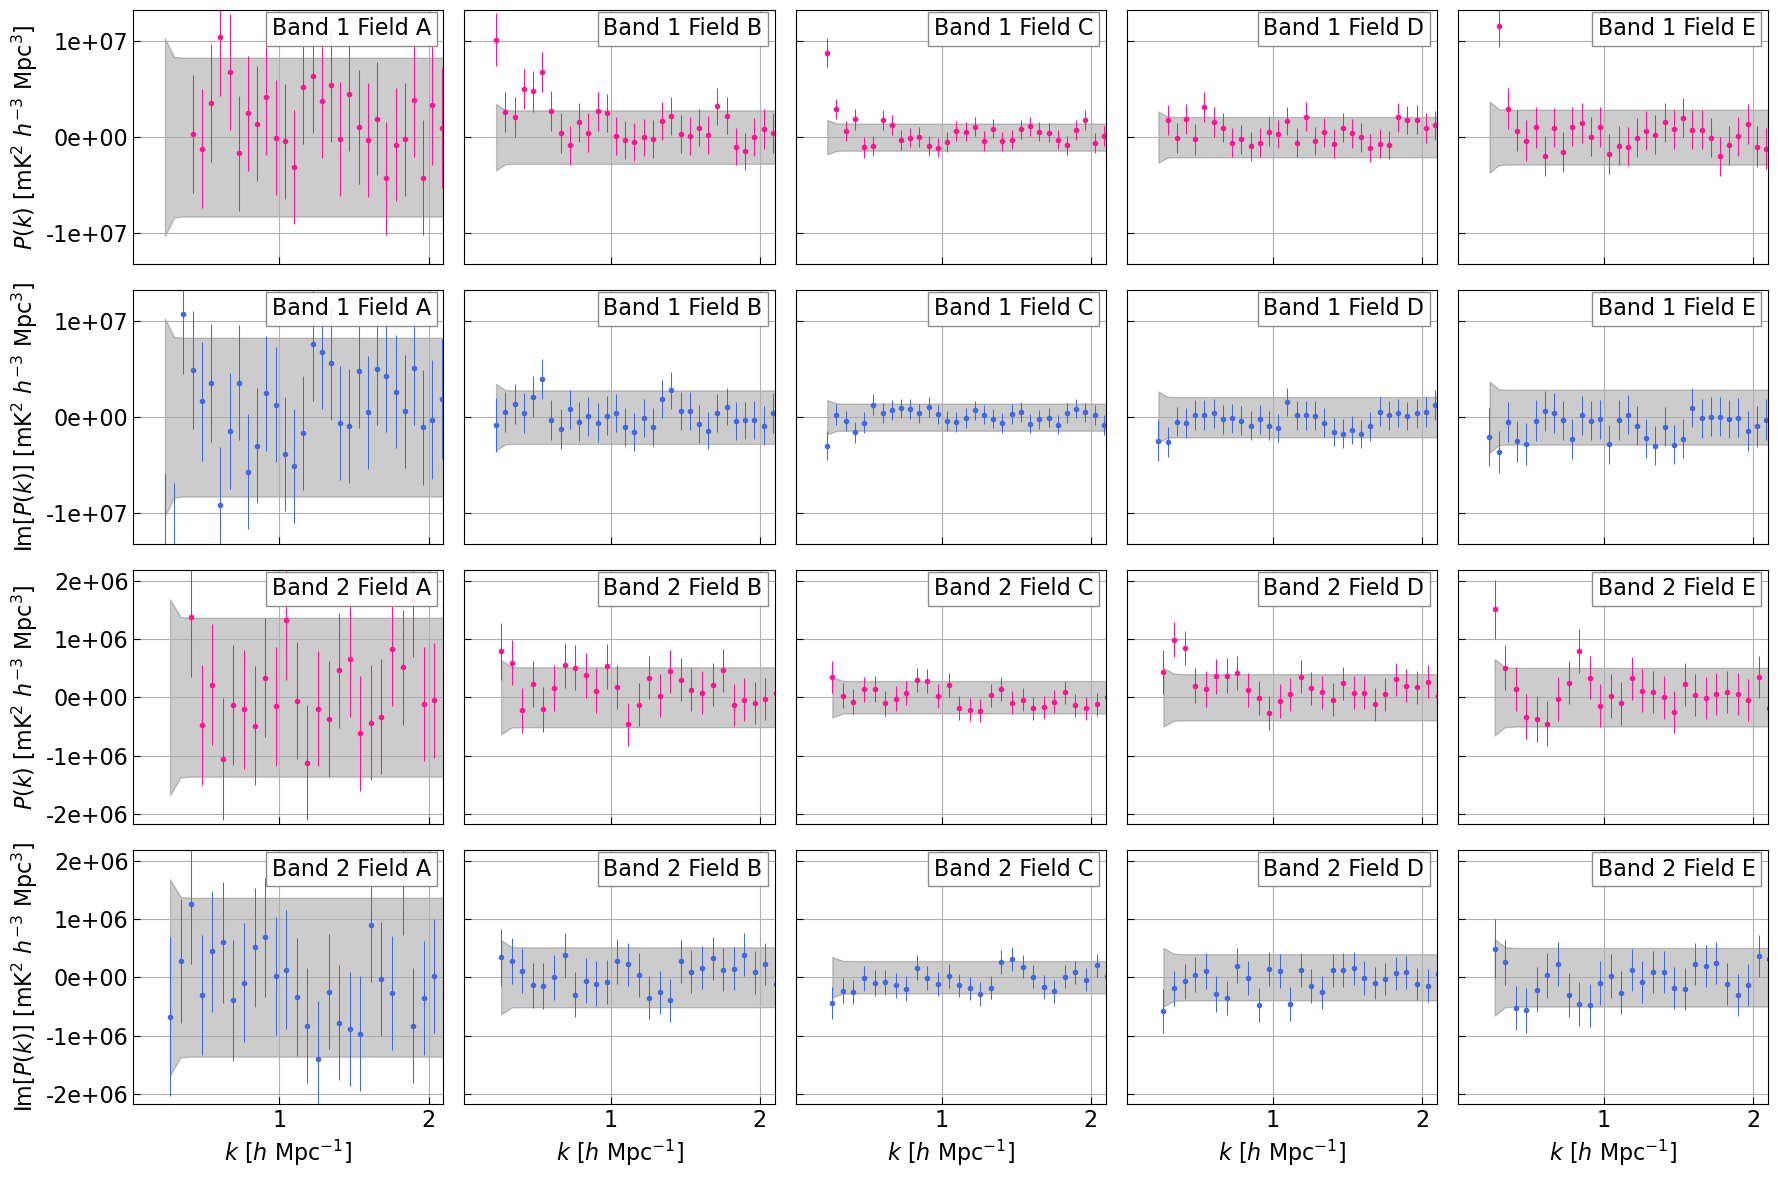

In [32]:
fig, axes = plt.subplots(4, len(uvp_xtk_sph_1), figsize=(18, 12))
fig.subplots_adjust(wspace=0.05, hspace=0.05)

# set params
xlim = .02, 2.1

for i in range(4):
    ylim_set = False
    spw = i // 2
    uvp_xtk_sph = [uvp_xtk_sph_1, uvp_xtk_sph_2][spw]
    for j in range(len(uvp_xtk_sph)):
        # get data
        ax = axes[i, j]
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0e'))
        u = uvp_xtk_sph[j]

        kp = u.get_kparas(spw)
        if i % 2 == 0:
            comp = np.real
            c = 'deeppink'
        else:
            comp = np.imag
            c = 'royalblue'
        y = comp(u.data_array[spw].squeeze().copy()).copy()
        yerr = np.sqrt(np.diagonal(u.cov_array_real[spw].squeeze()))
        pn = u.stats_array['P_N'][spw].real.squeeze()
        k = kp#ks[ks]
        
        # cut out bins with 0 or non-finite errors
        to_use = (pn > 0) | ~np.isfinite(pn)
        y = y[to_use]        
        yerr = yerr[to_use]
        pn = pn[to_use]
        k = k[to_use]
        if len(y) == 0:
            continue
                
        # plot data
        p1 = ax.errorbar(k, y, marker='o', ms=3, ls='',
                         yerr=yerr * 2, c=c, lw=.75)
        ax.fill_between(k, -2*pn, 2*pn, color='k', alpha=0.2, zorder=0)

        # handle subplot
        ax.tick_params(labelsize=16, direction='in', size=5)
        ax.tick_params(direction='in', size=3, which='minor')
        ax.grid()
        ax.set_xlim(xlim)
        if not ylim_set:
            ylim = -np.median(pn[np.isfinite(pn)])*3.2, np.median(pn[np.isfinite(pn)])*3.2
            ylim_set = True
        ax.set_ylim(ylim)
        ax.text(0.96, 0.9, "Band {} Field {}".format((i//2)+1, ("ABCDEFGHIJ"[fields_used[j]])), fontsize=16, ha='right',
                transform=ax.transAxes, bbox=dict(fc='w', ec='grey', alpha=0.9))
        if i < 3:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(r"$k\ [h\ {\rm Mpc}^{-1}]$", fontsize=16)
        if j == 0:
            if i % 2 == 0:
                ax.set_ylabel(r"$P(k)\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$", fontsize=16)
            else:
                ax.set_ylabel(r"Im$[P(k)]\ [{\rm mK}^2\ h^{-3}\ {\rm Mpc}^3]$", fontsize=16)
        else:
            ax.set_yticklabels([])

plt.tight_layout()
plt.savefig(f'{figures_folder}/{prefix}integrated_sph.png', dpi=200)

## Print table of upper limits

In [47]:
max_k = 1

for spw in [0, 1]:

    uvp_xtk_dsq = [uvp_xtk_dsq_1, uvp_xtk_dsq_2][spw]
    table_created = False
    for field in range(len(uvp_xtk_dsq)):
        ks = uvp_xtk_dsq[field].get_kparas(spw)
        deltasq = uvp_xtk_dsq[field].data_array[spw].squeeze().copy().real
        deltasq_err = np.sqrt(uvp_xtk_dsq[field].cov_array_real[spw].squeeze().diagonal())
        deltasq_ul = np.array([dsq if dsq > 0 else 0 for dsq in deltasq]) + 2 * deltasq_err

        to_use = (ks <= max_k) & (deltasq_err > 0)
        if len(deltasq_ul[to_use]) == 0:
            continue
        
        if not table_created:
            table = np.vstack([deltasq[to_use], deltasq_err[to_use], deltasq_ul[to_use]])
            table_created = True
        else:
            table = np.vstack([table, deltasq[to_use], deltasq_err[to_use], deltasq_ul[to_use]])

    df = pd.DataFrame(table.T)

    col_ix = pd.MultiIndex.from_product([[f'Field {"ABCDEFGHIJ"[field]}' for field in fields_used], 
                                         [r'$\Delta^{2}(k)$', r'$1\sigma$', r'$\Delta^{2}_{UL}$']]) 
    df.columns = col_ix
    df.insert(0, r"$k\ [h\ {\rm Mpc}^{-1}]$", ks[to_use])

    def css_border(x):
        return ["border-left: 1px solid black" if (i%3==1) else "border: 0px" for i, col in enumerate(x)]
    display(HTML(f'<h2>Band {spw+1}:</h2>'))
    
    to_display = df.style \
                   .format("{:,.2f}") \
                   .apply(css_border, axis=1) \
                   .set_properties(width='80px')
    
    display(HTML(to_display.to_html()))

# Save Results

In [49]:
# results are saved to h5 files per-band and per-field
for spw in [0, 1]:
    uvp_xtk_sph = [uvp_xtk_sph_1, uvp_xtk_sph_2][spw]
    for field in range(len(uvp_xtk_sph)):
        uvp = copy.deepcopy(uvp_xtk_sph[field])
        uvp.select(spws=[spw])
        outfilename = f'{results_folder}/{prefix}Pofk_Band_{spw+1}_Field_{"ABCDEFGHIJ"[field]}.h5'
        uvp.write_hdf5(outfilename, overwrite=True)
            
    uvp_xtk_dsq = [uvp_xtk_dsq_1, uvp_xtk_dsq_2][spw]    
    for field in range(len(uvp_xtk_dsq)):
        uvp = copy.deepcopy(uvp_xtk_dsq[field])
        uvp.select(spws=[spw])
        outfilename = f'{results_folder}/{prefix}Deltasq_Band_{spw+1}_Field_{"ABCDEFGHIJ"[field]}.h5'
        uvp.write_hdf5(outfilename, overwrite=True)    